### SP025 Integration analysis TME 

In [1]:
import scanpy as sc
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sb
from gprofiler import GProfiler
import loompy as lp
import rpy2.rinterface_lib.callbacks
import logging
import scrublet as scr
from rpy2.robjects import pandas2ri
import anndata2ri

In [2]:
sc.logging.print_header()

scanpy==1.6.0 anndata==0.7.5 umap==0.4.6 numpy==1.19.4 scipy==1.4.1 pandas==1.1.4 scikit-learn==0.23.2 statsmodels==0.12.1 python-igraph==0.8.3 louvain==0.7.0 leidenalg==0.8.2


In [3]:
# Ignore R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

# Automatically convert rpy2 outputs to pandas dataframes
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

plt.rcParams['figure.figsize']=(8,8) #rescale figures
sc.settings.verbosity = 3
#sc.set_figure_params(dpi=200, dpi_save=300)
sc.logging.print_header()

scanpy==1.6.0 anndata==0.7.5 umap==0.4.6 numpy==1.19.4 scipy==1.4.1 pandas==1.1.4 scikit-learn==0.23.2 statsmodels==0.12.1 python-igraph==0.8.3 louvain==0.7.0 leidenalg==0.8.2


In [4]:
%%R
# Load libraries from correct lib Paths for my environment - ignore this!
.libPaths("/home/spuccio/miniconda3/envs/scrnseq/lib/R/library")

# Load all the R libraries we will be using in the notebook
library(scran)
library(RColorBrewer)
library(slingshot)
library(monocle)
library(gam)
library(clusterExperiment)
library(ggplot2)
library(plyr)
library(MAST)
library(clustree)
library(SingleCellExperiment)
library(CHETAH)
library(SingleR)
library(cowplot)
library(Matrix)

### Load Dataset CRC 

In [5]:
path_CRC="/home/spuccio/isilon/spuccio/SP025_NaClTcell/PangenomeBlueprint/CRC_counts/"
adata_CRC = sc.read("".join([path_CRC,"matrix.mtx"]), cache=True)
adata_CRC = adata_CRC.transpose()
adata_CRC.X = adata_CRC.X.toarray()
barcodes = pd.read_csv("".join([path_CRC,"barcodes.tsv"]), header=None, sep='\t')
genes = pd.read_csv("".join([path_CRC,"genes.tsv"]), header=None, sep='\t')
#Annotate data
barcodes.rename(columns={0:'barcode'}, inplace=True)
barcodes.set_index('barcode', inplace=True)
adata_CRC.obs = barcodes
genes.rename(columns={0:'gene_id', 1:'gene_symbol'}, inplace=True)
genes.set_index('gene_symbol', inplace=True)
adata_CRC.var = genes
Metadata_CRC = pd.read_csv("/home/spuccio/isilon/spuccio/SP025_NaClTcell/PangenomeBlueprint/CRC_metadata_2.csv",header=0,low_memory=False)
adata_CRC.obs['CellId'] = Metadata_CRC["Cell"].to_list()
adata_CRC.obs['CellFromTumor'] = Metadata_CRC["CellFromTumor"].to_list()
adata_CRC.obs['PatientNumber'] = Metadata_CRC["PTZ_PatientNumber"].to_list()
adata_CRC.obs['TumorType'] = Metadata_CRC["TumorType"].to_list()
adata_CRC.obs['TumorSite'] = Metadata_CRC["TumorSite"].to_list()
adata_CRC.obs['CellType'] = Metadata_CRC["CellType"].to_list()

... reading from cache file cache/home-spuccio-isilon-spuccio-SP025_NaClTcell-PangenomeBlueprint-CRC_counts-matrix.h5ad


In [6]:
adata_CRC_Tcell = adata_CRC[adata_CRC.obs['CellType']  == "T_cell",:]
adata_CRC_Cancer = adata_CRC[adata_CRC.obs['CellType']  == "Cancer",:]

### Filter low expressed genes

In [7]:
sc.pp.filter_genes(adata_CRC_Tcell, min_cells=10)
sc.pp.filter_cells(adata_CRC_Tcell, min_genes=200)

filtered out 18311 genes that are detected in less than 10 cells


Trying to set attribute `.var` of view, copying.


filtered out 1 cells that have less than 200 genes expressed


In [8]:
adata_CRC_Tcell.raw = adata_CRC_Tcell

### QC metrics

In [9]:
sc.pp.calculate_qc_metrics(adata_CRC_Tcell, inplace=True)

In [10]:
adata_CRC_Tcell.var['mt'] = adata_CRC_Tcell.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata_CRC_Tcell, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

In [11]:
adata_CRC_Tcell.var['rb'] = adata_CRC_Tcell.var_names.str.startswith('RP')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata_CRC_Tcell, qc_vars=['rb'], percent_top=None, log1p=False, inplace=True)

In [12]:
#sc.pl.violin(adata_CRC_Tcell, ['pct_counts_mt'],
#             jitter=0.4, multi_panel=False)

normalizing counts per cell
    finished (0:00:00)


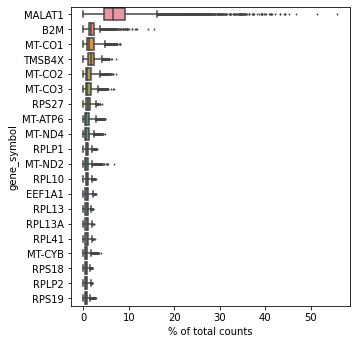

In [13]:
sc.pl.highest_expr_genes(adata_CRC_Tcell, n_top=20)

In [14]:
print("Cell x Genes before filtering")
print(adata_CRC_Tcell.n_obs, adata_CRC_Tcell.n_vars)

Cell x Genes before filtering
8787 15383


In [15]:
adata_CRC_Tcell = adata_CRC_Tcell[adata_CRC_Tcell.obs.pct_counts_rb < 45, :]
print("Cell x Genes after filtering cell with high ribosomial")
print(adata_CRC_Tcell.n_obs, adata_CRC_Tcell.n_vars)

Cell x Genes after filtering cell with high ribosomial
8051 15383


In [16]:
adata_CRC_Tcell = adata_CRC_Tcell[adata_CRC_Tcell.obs.pct_counts_mt < 10, :]
print("Cell x Genes after filtering cell with high mithocondrial")
print(adata_CRC_Tcell.n_obs, adata_CRC_Tcell.n_vars)

Cell x Genes after filtering cell with high mithocondrial
5383 15383


In [17]:
annot = sc.queries.biomart_annotations(
        "hsapiens",
        ["external_gene_name", "start_position", "end_position", "chromosome_name","gene_biotype"],).set_index("external_gene_name")

In [18]:
annot['gene_biotype'].unique()

array(['Mt_tRNA', 'Mt_rRNA', 'protein_coding', 'processed_pseudogene',
       'lncRNA', 'snRNA', 'unprocessed_pseudogene', 'misc_RNA',
       'transcribed_unprocessed_pseudogene',
       'transcribed_processed_pseudogene', 'TEC', 'rRNA',
       'IG_V_pseudogene', 'rRNA_pseudogene', 'miRNA',
       'transcribed_unitary_pseudogene', 'unitary_pseudogene', 'snoRNA',
       'scaRNA', 'polymorphic_pseudogene', 'pseudogene', 'ribozyme',
       'sRNA', 'TR_V_gene', 'TR_V_pseudogene', 'TR_D_gene', 'TR_J_gene',
       'TR_C_gene', 'TR_J_pseudogene', 'IG_C_gene', 'IG_C_pseudogene',
       'IG_J_gene', 'IG_J_pseudogene', 'IG_D_gene', 'IG_V_gene',
       'IG_pseudogene', 'translated_processed_pseudogene', 'scRNA',
       'vault_RNA', 'translated_unprocessed_pseudogene'], dtype=object)

In [19]:
#len(pd.merge(pd.DataFrame(adata_CRC_Tcell.var_names),annot,left_on="gene_symbol",right_on="external_gene_name",how="left"))

In [20]:
annot = pd.merge(pd.DataFrame(adata_CRC_Tcell.var_names),annot,left_on="gene_symbol",right_on="external_gene_name",how="left")

In [21]:
annot= annot.drop_duplicates(['gene_symbol'])

In [22]:
annot = annot.fillna("Not_available")

In [23]:
adata_CRC_Tcell.var['gene_biotype'] = annot.set_index("gene_symbol")['gene_biotype']
protein_coding = annot['gene_symbol'].loc[annot['gene_biotype']=="protein_coding"].reset_index()
del protein_coding['index']
protein_gene_indicator = np.in1d(adata_CRC_Tcell.var_names, protein_coding)
adata_CRC_Tcell = adata_CRC_Tcell[:, protein_gene_indicator]

Trying to set attribute `.var` of view, copying.


In [24]:
mito_gene_names = sc.queries.mitochondrial_genes("hsapiens")

In [25]:
mito_gene_indicator = np.in1d(adata_CRC_Tcell.var_names, mito_gene_names)

In [26]:
adata_CRC_Tcell = adata_CRC_Tcell[:, ~mito_gene_indicator]

In [27]:
adata_CRC_Tcell

View of AnnData object with n_obs × n_vars = 5383 × 12716
    obs: 'CellId', 'CellFromTumor', 'PatientNumber', 'TumorType', 'TumorSite', 'CellType', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'pct_counts_mt', 'total_counts_rb', 'pct_counts_rb'
    var: 'gene_id', 'n_cells', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mt', 'rb', 'gene_biotype'

In [28]:
print(adata_CRC_Tcell.n_obs, adata_CRC_Tcell.n_vars)
malat1 = adata_CRC_Tcell.var_names.str.startswith('MALAT1')
#protein_genes= adata_CRC_Tcell.var.gene_biotype.str.startswith('protein_coding')
ribo_genes = adata_CRC_Tcell.var_names.str.startswith(("RPS","RPL"))
remove = np.add(ribo_genes, malat1)
keep = np.invert(remove)

adata_CRC_Tcell = adata_CRC_Tcell[:,keep]

print(adata_CRC_Tcell.n_obs, adata_CRC_Tcell.n_vars)

5383 12716
5383 12621


In [29]:
print(adata_CRC_Tcell.n_obs, adata_CRC_Tcell.n_vars)

5383 12621


In [30]:
adata_CRC_Tcell.raw = adata_CRC_Tcell

In [31]:
sc.pp.normalize_total(adata_CRC_Tcell, target_sum=1e4,exclude_highly_expressed=True)
sc.pp.log1p(adata_CRC_Tcell)

normalizing counts per cell The following highly-expressed genes are not considered during normalization factor computation:
['GNLY', 'JCHAIN', 'CXCL13', 'EEF1A1', 'TMSB4X', 'HBB', 'FTH1', 'SRGN', 'CD69', 'GZMB', 'B2M', 'HBA2', 'HBA1', 'CCL4', 'CCL4L2', 'FTL']
    finished (0:00:00)


In [32]:
sc.pp.highly_variable_genes(adata_CRC_Tcell, min_mean=0.0125, max_mean=3, min_disp=0.5)

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [33]:
adata_CRC_Tcell.raw = adata_CRC_Tcell

In [34]:
#pd.DataFrame(adata_CRC_Tcell.var.highly_variable).loc[pd.DataFrame(adata_CRC_Tcell.var.highly_variable)['highly_variable'] == True].head(50)

normalizing counts per cell
    finished (0:00:00)


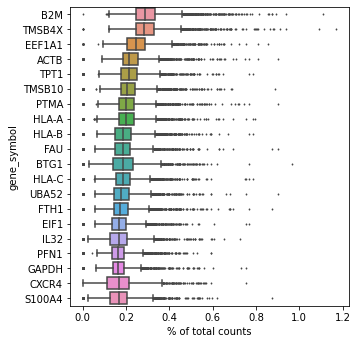

In [35]:
sc.pl.highest_expr_genes(adata_CRC_Tcell, n_top=20)

### Principal component analysis

In [36]:
#adata_CRC_Tcell = adata_CRC_Tcell[:, adata_CRC_Tcell.var.highly_variable]

In [37]:
#sc.pp.scale(adata_CRC_Tcell, max_value=10)

In [38]:
sc.tl.pca(adata_CRC_Tcell, svd_solver='arpack',use_highly_variable=True)

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)


... storing 'PatientNumber' as categorical
... storing 'TumorType' as categorical
... storing 'TumorSite' as categorical
... storing 'CellType' as categorical
... storing 'gene_biotype' as categorical


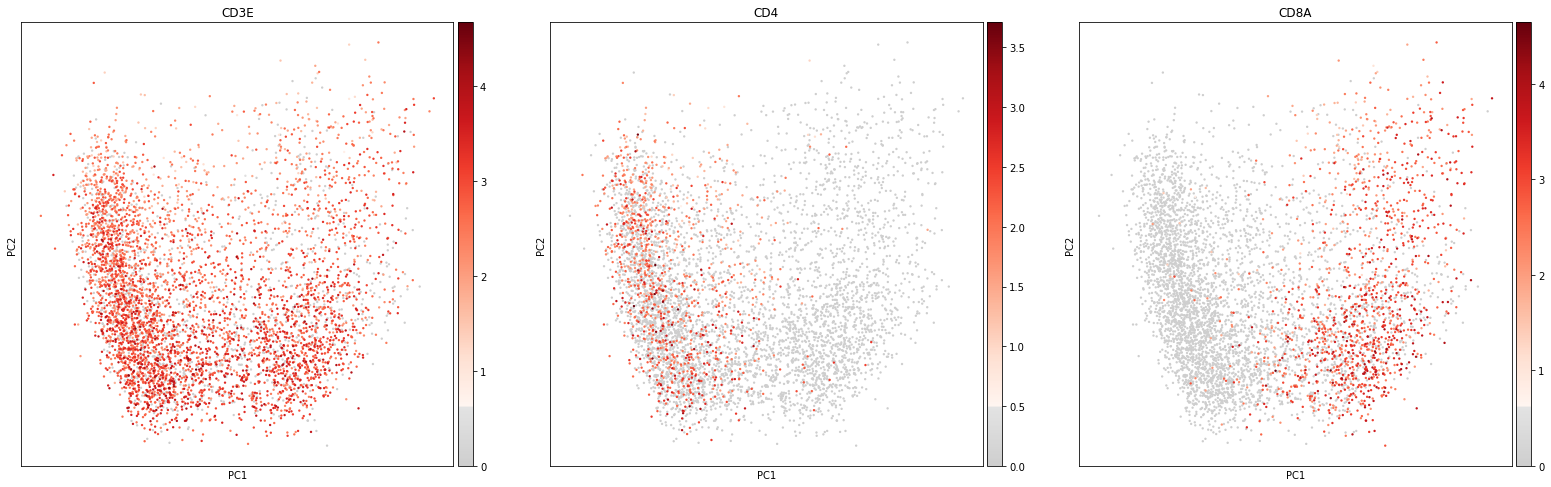

In [39]:

colors2 = plt.cm.Reds(np.linspace(0, 1, 128))
colors3 = plt.cm.Greys_r(np.linspace(0.7,0.8,20))
colorsComb = np.vstack([colors3, colors2])
mymap = colors.LinearSegmentedColormap.from_list('my_colormap', colorsComb)
sc.pl.pca(adata_CRC_Tcell, color=['CD3E','CD4','CD8A'],color_map=mymap)

### Computing the neighborhood graph

In [40]:
sc.pp.neighbors(adata_CRC_Tcell, n_neighbors=10, n_pcs=40)

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)


### Embedding the neighborhood graph

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:12)


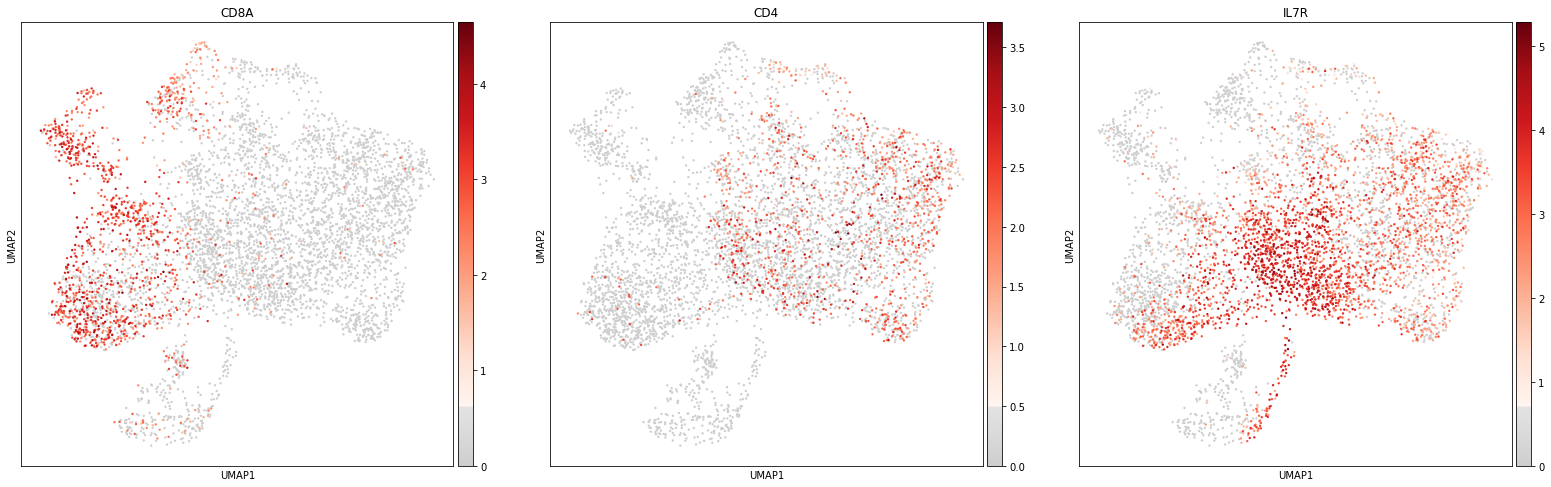

In [41]:
sc.tl.umap(adata_CRC_Tcell)
sc.pl.umap(adata_CRC_Tcell, color=['CD8A', 'CD4', 'IL7R'],color_map=mymap,use_raw=True); plt.show()

### Clustering the neighborhood graph

In [42]:
sc.tl.leiden(adata_CRC_Tcell, resolution=0.7, key_added='leiden_r7_clusters')
sc.tl.leiden(adata_CRC_Tcell, resolution=0.5, key_added='leiden_r5_clusters')
sc.tl.leiden(adata_CRC_Tcell, resolution=0.4, key_added='leiden_r4_clusters')
sc.tl.leiden(adata_CRC_Tcell, resolution=0.6, key_added='leiden_r6_clusters')
sc.tl.leiden(adata_CRC_Tcell, resolution=0.8, key_added='leiden_r8_clusters')

running Leiden clustering
    finished: found 12 clusters and added
    'leiden_r7_clusters', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 9 clusters and added
    'leiden_r5_clusters', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 8 clusters and added
    'leiden_r4_clusters', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 10 clusters and added
    'leiden_r6_clusters', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 13 clusters and added
    'leiden_r8_clusters', the cluster labels (adata.obs, categorical) (0:00:00)


In [43]:
data_clus = adata_CRC_Tcell.obs[['leiden_r7_clusters','leiden_r6_clusters','leiden_r5_clusters','leiden_r4_clusters','leiden_r8_clusters']]

In [44]:
data_clus.to_csv("/mnt/lugli/spuccio/SP028_Autoimmunity/h5_files/temp.csv",index=True,header=True)
data_clus2 = pd.read_csv("/mnt/lugli/spuccio/SP028_Autoimmunity/h5_files/temp.csv",index_col=0,header=0)

In [45]:
# these are the defaults we want to set:
default_units = 'in' # inch, to make it more easily comparable to matpplotlib
default_res = 100 # dpi, same as default in matplotlib
default_width = 10
default_height = 9
# try monkey-patching a function in rpy2, so we effectively get these
# default settings for the width, height, and units arguments of the %R magic command
import rpy2
old_setup_graphics = rpy2.ipython.rmagic.RMagics.setup_graphics

def new_setup_graphics(self, args):
    if getattr(args, 'units') is not None:
        if args.units != default_units: # a different units argument was passed, do not apply defaults
            return old_setup_graphics(self, args)
    args.units = default_units
    if getattr(args, 'res') is None:
        args.res = default_res
    if getattr(args, 'width') is None:
        args.width = default_width
    if getattr(args, 'height') is None:
        args.height = default_height        
    return old_setup_graphics(self, args)

rpy2.ipython.rmagic.RMagics.setup_graphics = new_setup_graphics

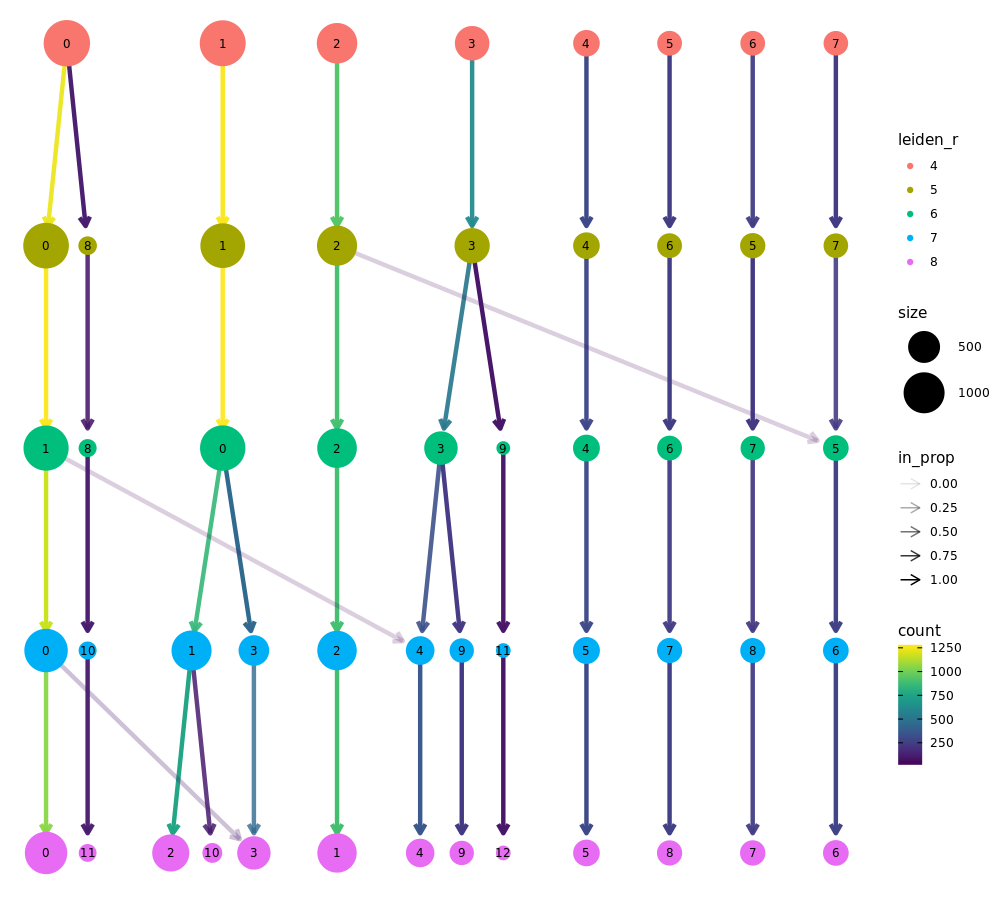

In [46]:
%%R -i data_clus2
library(clustree)

clustree(data_clus2,prefix="leiden_r",suffix = "_clusters")

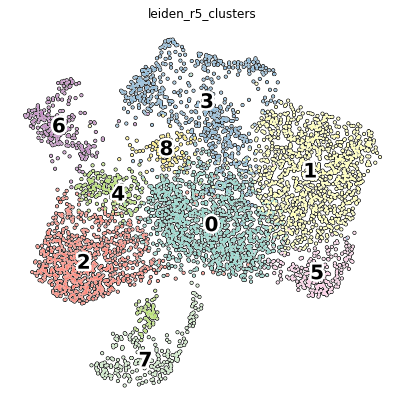

In [47]:
rcParams['figure.figsize'] = 7, 7
sc.pl.umap(adata_CRC_Tcell, color='leiden_r5_clusters', add_outline=True,legend_loc='on data', 
           legend_fontsize=20, legend_fontoutline=5,frameon=False,
           title='leiden_r5_clusters', palette='Set3')

In [48]:
sc.tl.paga(adata_CRC_Tcell,groups='leiden_r5_clusters')
sc.pl.paga(adata_CRC_Tcell, plot=False)  # remove `plot=False` if you want to see the coarse-grained graph
sc.tl.umap(adata_CRC_Tcell, init_pos='paga')

running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)
--> added 'pos', the PAGA positions (adata.uns['paga'])
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:12)


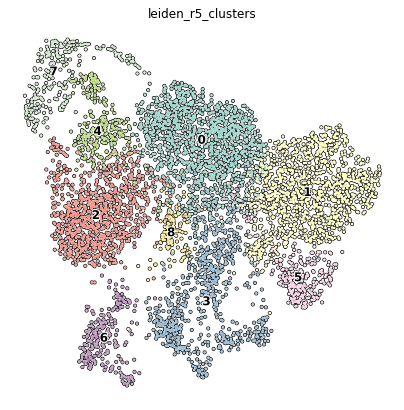

In [49]:
rcParams['figure.figsize'] = 7, 7
sc.pl.umap(adata_CRC_Tcell, color='leiden_r5_clusters', add_outline=True,legend_loc='on data', 
           legend_fontsize=12, legend_fontoutline=2,frameon=False,
           title='leiden_r5_clusters', palette='Set3')

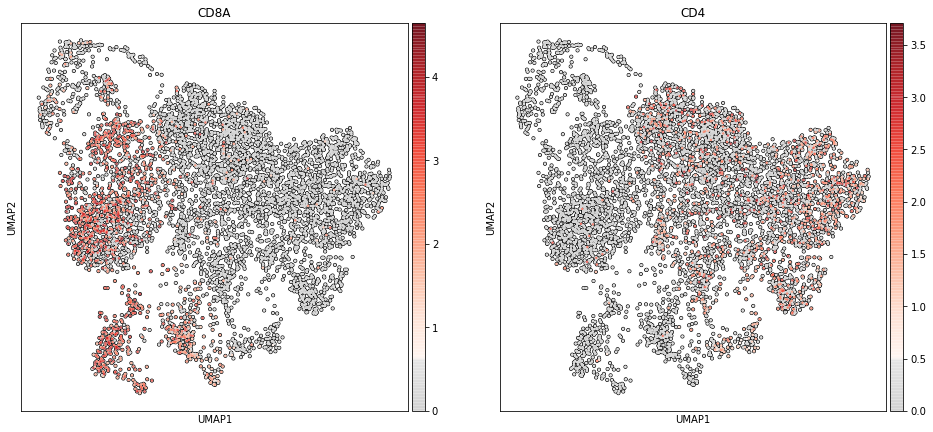

In [50]:
sc.pl.umap(adata_CRC_Tcell, color=['CD8A','CD4'],color_map=mymap,add_outline=True,legend_loc='on data', )

### Finding marker genes

In [51]:
sc.tl.rank_genes_groups(adata_CRC_Tcell, 'leiden_r5_clusters', method='wilcoxon')
pd.DataFrame(adata_CRC_Tcell.uns['rank_genes_groups']['names']).head(50)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:07)


,0,1,2,3,4,5,6,7,8
0,IL7R,TNFRSF4,GZMK,HSP90AA1,CCL5,CXCL13,GZMB,TYROBP,CKLF
1,EEF1A1,BATF,CST7,CRIP1,KLRD1,SRGN,GZMH,AREG,GZMB
2,TPT1,TNFRSF18,NKG7,FAM118A,CD7,FKBP5,CD8A,FCER1G,CAPG
3,TXNIP,IL32,CCL5,HSPA1A,TMSB4X,NR3C1,NKG7,GNLY,SH3BGRL3
4,TSC22D3,LTB,CCL4,DNAJB1,GZMA,ITM2A,APOBEC3G,KLRD1,S100A4
5,UBA52,BIRC3,GZMA,HSPH1,HOPX,SLA,CCL5,NKG7,GZMA
6,BTG1,SAT1,DUSP2,ENTPD1,ID2,ICA1,HLA-DRB1,CTSW,CD3D
7,EEF1B2,IL2RA,CXCR4,HSPA1B,NKG7,IL6ST,CTSW,PRF1,VIM
8,CD40LG,FOXP3,HCST,TNFAIP3,CD63,EEF1A1,LAG3,IFITM2,ALOX5AP
9,TOMM7,PMAIP1,CMC1,ARPC2,CD8A,TMEM243,HLA-DRA,KLRC1,LGALS3


/home/spuccio/miniconda3/envs/cytophenograph/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/spuccio/miniconda3/envs/cytophenograph/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/spuccio/miniconda3/envs/cytophenograph/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will

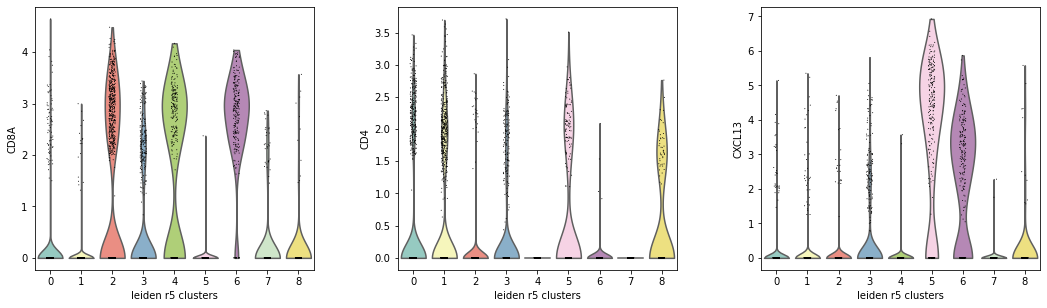

In [52]:
rcParams['figure.figsize'] = 5,5
sc.pl.violin(adata_CRC_Tcell, ['CD8A', 'CD4','CXCL13'], groupby='leiden_r5_clusters')

/home/spuccio/miniconda3/envs/cytophenograph/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/spuccio/miniconda3/envs/cytophenograph/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/spuccio/miniconda3/envs/cytophenograph/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will

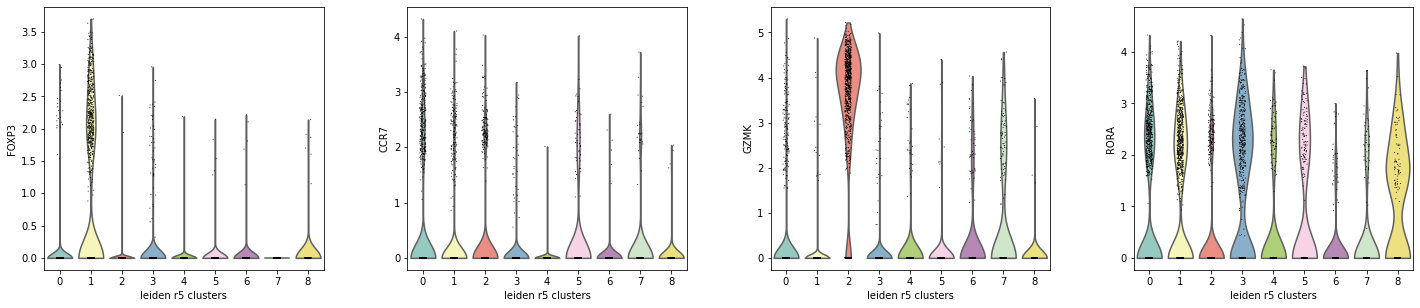

/home/spuccio/miniconda3/envs/cytophenograph/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/spuccio/miniconda3/envs/cytophenograph/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/spuccio/miniconda3/envs/cytophenograph/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will

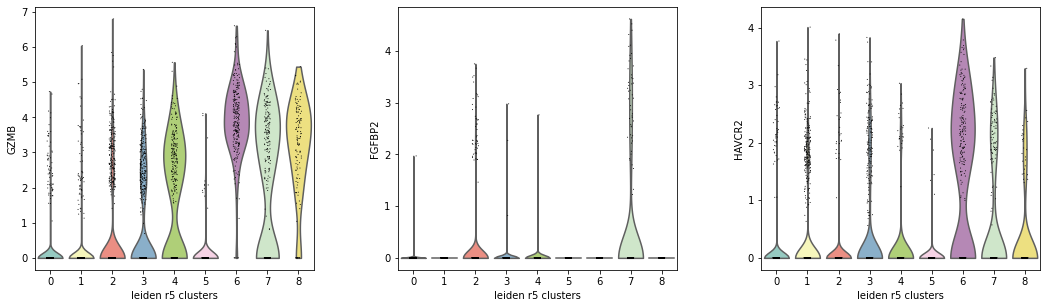

In [53]:
rcParams['figure.figsize'] = 5,5
sc.pl.violin(adata_CRC_Tcell, ['FOXP3','CCR7','GZMK','RORA'], groupby='leiden_r5_clusters' )
sc.pl.violin(adata_CRC_Tcell, ['GZMB','FGFBP2','HAVCR2'], groupby='leiden_r5_clusters' )

/home/spuccio/miniconda3/envs/cytophenograph/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/spuccio/miniconda3/envs/cytophenograph/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/spuccio/miniconda3/envs/cytophenograph/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will

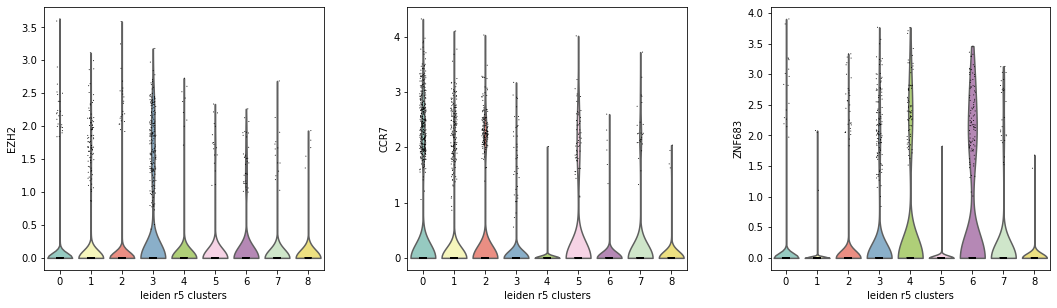

In [54]:
sc.pl.violin(adata_CRC_Tcell, ['EZH2','CCR7','ZNF683'], groupby='leiden_r5_clusters' )

In [55]:
new_cluster_names = [
    'C0_CD4_CCR7', 'C1_CD4_FOXP3','C2_CD8_GZMK','C3_CD4_EZH2','C4_CD8_ZNF683','C5_CD4_CXCL13','C6_CD8_HAVCR2','C7_NK_FGFBP','C8_CD4_RORA']
adata_CRC_Tcell.rename_categories('leiden_r5_clusters', new_cluster_names)

In [56]:
adata_CRC_Tcell.obs['leiden_r5_clusters']

barcode
scrEXT001_AAACCTGTCGTCCAGG     C1_CD4_FOXP3
scrEXT001_AAAGATGAGAATTCCC      C0_CD4_CCR7
scrEXT001_AAATGCCCAGCGAACA     C1_CD4_FOXP3
scrEXT001_AACCATGCATTAACCG      C0_CD4_CCR7
scrEXT001_AACTCAGGTCGGCATC      C0_CD4_CCR7
                                  ...      
scrEXT029_GTAGGCCCAGACGCAA      C0_CD4_CCR7
scrEXT029_TCTTCGGCATAGTAAG      C0_CD4_CCR7
scrEXT029_TGACAACGTATGAAAC      C0_CD4_CCR7
scrEXT029_TGACTAGGTGTTCTTT    C4_CD8_ZNF683
scrEXT029_TGGCCAGCAATCTGCA      C0_CD4_CCR7
Name: leiden_r5_clusters, Length: 5383, dtype: category
Categories (9, object): ['C0_CD4_CCR7', 'C1_CD4_FOXP3', 'C2_CD8_GZMK', 'C3_CD4_EZH2', ..., 'C5_CD4_CXCL13', 'C6_CD8_HAVCR2', 'C7_NK_FGFBP', 'C8_CD4_RORA']

In [57]:
marker_genes_dict = {'T-cell': ['CD8A','CD4'],
                     'C0_CD4_CCR7': ['CCR7'],
                     'C1_CD4_FOXP3': ['FOXP3'],
                     'C2_CD8_GZMK': ['GZMK'],
                     'C3_CD4_EZH2': ['EZH2'],
                     'C4_CD8_ZNF683': ['ZNF683'],
                     'C5_CD4_CXCL13': ['CXCL13'],
                     'C6_CD8_HAVCR2' : ['HAVCR2'],
                     'C7_NK_FGFBP' : ['FGFBP2','NKG7'],
                     'C8_CD4_RORA' : ['RORA']}

    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns["dendrogram_['leiden_r5_clusters']"]`
categories: C0_CD4_CCR7, C1_CD4_FOXP3, C2_CD8_GZMK, etc.
var_group_labels: T-cell, C0_CD4_CCR7, C1_CD4_FOXP3, etc.


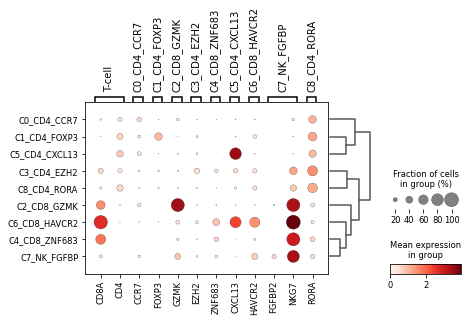

In [58]:
rcParams['figure.figsize'] = 10,10
sc.pl.dotplot(adata_CRC_Tcell, marker_genes_dict, 'leiden_r5_clusters', dendrogram=True)

In [60]:
sc.tl.dendrogram(adata_CRC_Tcell, 'leiden_r5_clusters')

    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns["dendrogram_['leiden_r5_clusters']"]`


    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_leiden_r5_clusters']`


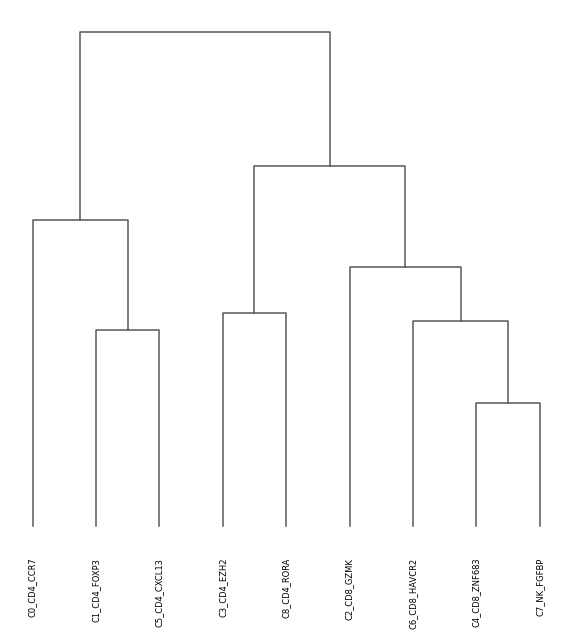

In [61]:
ax = sc.pl.dendrogram(adata_CRC_Tcell, 'leiden_r5_clusters')

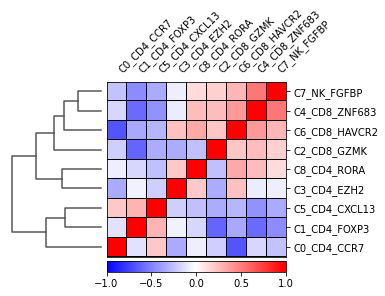

In [62]:
ax = sc.pl.correlation_matrix(adata_CRC_Tcell, 'leiden_r5_clusters', figsize=(5,3.5))

In [63]:
adata_CRC_Tcell.obs['leiden_r5_clusters'].value_counts()

C0_CD4_CCR7      1337
C1_CD4_FOXP3     1264
C2_CD8_GZMK       944
C3_CD4_EZH2       659
C4_CD8_ZNF683     301
C5_CD4_CXCL13     261
C6_CD8_HAVCR2     248
C7_NK_FGFBP       242
C8_CD4_RORA       127
Name: leiden_r5_clusters, dtype: int64

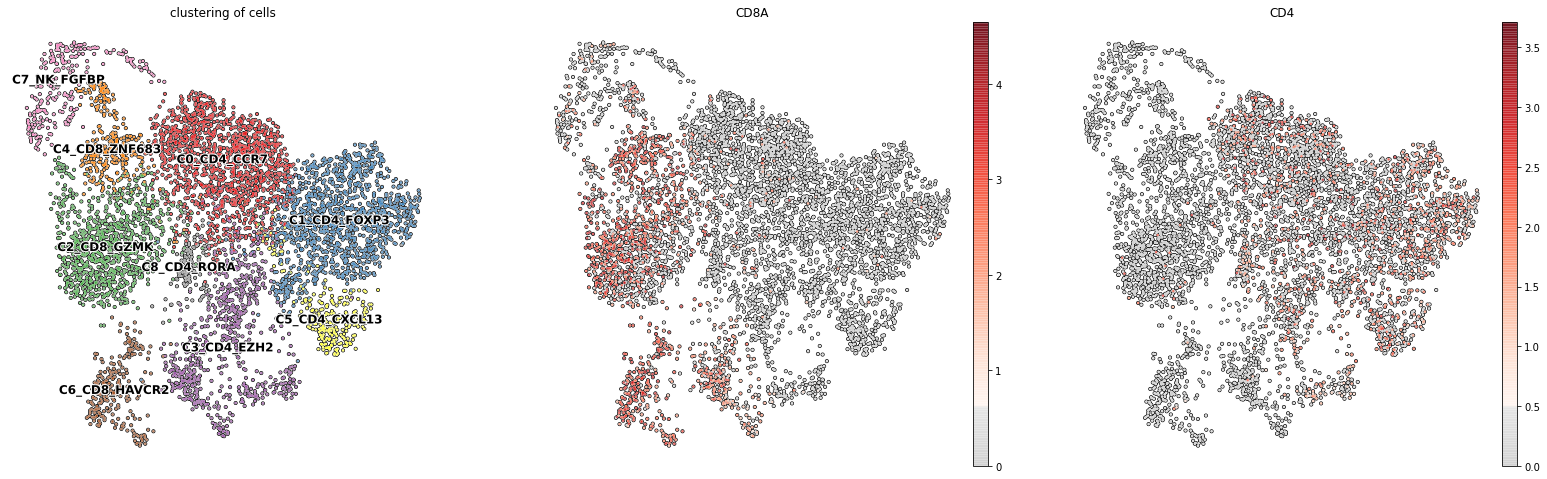

In [64]:
rcParams['figure.figsize'] = 8, 8
sc.pl.umap(adata_CRC_Tcell, color=['leiden_r5_clusters','CD8A','CD4'],color_map=mymap, add_outline=True,legend_loc='on data', 
           legend_fontsize=12, legend_fontoutline=2,frameon=False,
           title='clustering of cells', palette='Set1')

### Filter NK cluster and compute again DEGS

In [65]:
adata_CRC_Tcell_sub = adata_CRC_Tcell[adata_CRC_Tcell.obs['leiden_r5_clusters'].isin(['C0_CD4_CCR7', 'C1_CD4_FOXP3','C2_CD8_GZMK','C3_CD4_EZH2','C4_CD8_ZNF683','C5_CD4_CXCL13','C6_CD8_HAVCR2','C8_CD4_RORA']),:]

In [66]:
adata_CRC_Tcell_sub

View of AnnData object with n_obs × n_vars = 5141 × 12621
    obs: 'CellId', 'CellFromTumor', 'PatientNumber', 'TumorType', 'TumorSite', 'CellType', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'pct_counts_mt', 'total_counts_rb', 'pct_counts_rb', 'leiden_r7_clusters', 'leiden_r5_clusters', 'leiden_r4_clusters', 'leiden_r6_clusters', 'leiden_r8_clusters'
    var: 'gene_id', 'n_cells', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mt', 'rb', 'gene_biotype', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_r5_clusters_colors', 'paga', 'leiden_r5_clusters_sizes', 'rank_genes_groups', "dendrogram_['leiden_r5_clusters']", 'dendrogram_leiden_r5_c

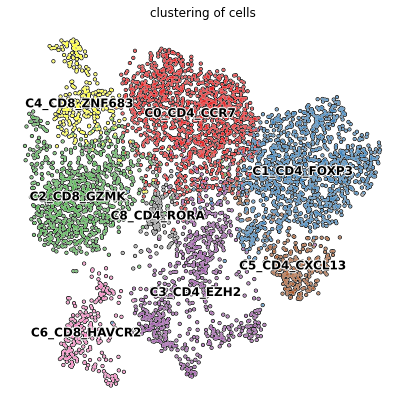

In [68]:
rcParams['figure.figsize'] = 7, 7
sc.pl.umap(adata_CRC_Tcell_sub, color=['leiden_r5_clusters'], add_outline=True,legend_loc='on data', 
           legend_fontsize=12, legend_fontoutline=2,frameon=False,
           title='clustering of cells', palette='Set1',color_map=mymap)

In [69]:
sc.tl.rank_genes_groups(adata_CRC_Tcell_sub, 'leiden_r5_clusters', method='wilcoxon')

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:06)


In [70]:
pd.DataFrame(adata_CRC_Tcell_sub.uns['rank_genes_groups']['names']).head(50)

,C0_CD4_CCR7,C1_CD4_FOXP3,C2_CD8_GZMK,C3_CD4_EZH2,C4_CD8_ZNF683,C5_CD4_CXCL13,C6_CD8_HAVCR2,C8_CD4_RORA
0,IL7R,TNFRSF4,GZMK,HSP90AA1,CCL5,CXCL13,GZMB,GZMB
1,EEF1A1,TNFRSF18,NKG7,CRIP1,KLRD1,SRGN,GZMH,CKLF
2,TPT1,BATF,CST7,FAM118A,CD7,FKBP5,NKG7,CAPG
3,TXNIP,IL32,CCL5,HSPA1A,TMSB4X,NR3C1,CD8A,SH3BGRL3
4,TSC22D3,LTB,CCL4,HSPH1,HOPX,ITM2A,CTSW,GZMA
5,UBA52,SAT1,GZMA,DNAJB1,GZMA,SLA,APOBEC3G,S100A4
6,EEF1B2,IL2RA,DUSP2,ENTPD1,ID2,ICA1,CCL5,ALOX5AP
7,BTG1,BIRC3,CXCR4,HSPA1B,NKG7,NFKBIA,HLA-DRB1,LGALS3
8,FOS,FOXP3,HCST,TNFAIP3,CD63,EEF1A1,LAG3,ANKRD28
9,ANXA1,PMAIP1,CMC1,ARPC2,HCST,IL6ST,HLA-DRA,VIM


### Cluster information

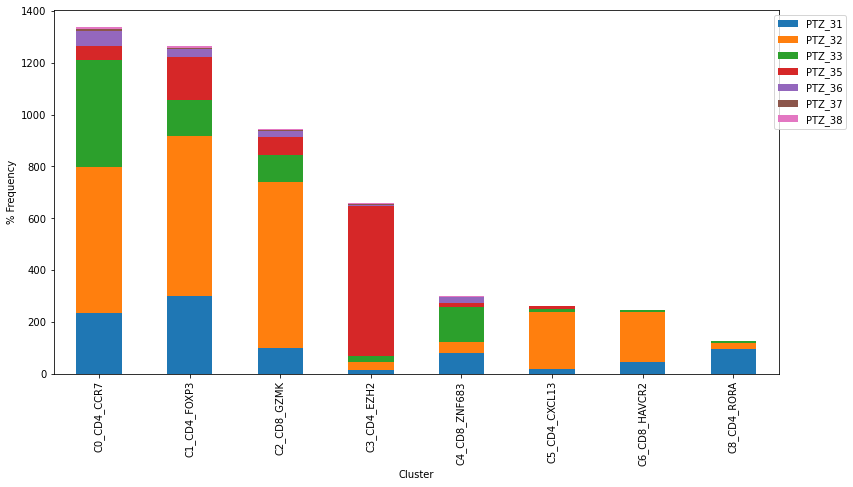

In [71]:
fig, (ax1) = plt.subplots(1,1, figsize=(33/2.54, 17/2.54))
ax1 = adata_CRC_Tcell_sub.obs.groupby("leiden_r5_clusters")["PatientNumber"].value_counts(normalize=False).unstack().plot.bar(stacked=True,legend=False,ax=ax1)
ax1.set_xlabel("Cluster")
ax1.set_ylabel("% Frequency")
ax1.grid(False)
ax1.legend(bbox_to_anchor=(1.1, 1.0))

In [72]:
adata_CRC_Tcell_sub

AnnData object with n_obs × n_vars = 5141 × 12621
    obs: 'CellId', 'CellFromTumor', 'PatientNumber', 'TumorType', 'TumorSite', 'CellType', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'pct_counts_mt', 'total_counts_rb', 'pct_counts_rb', 'leiden_r7_clusters', 'leiden_r5_clusters', 'leiden_r4_clusters', 'leiden_r6_clusters', 'leiden_r8_clusters'
    var: 'gene_id', 'n_cells', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mt', 'rb', 'gene_biotype', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_r5_clusters_colors', 'paga', 'leiden_r5_clusters_sizes', 'rank_genes_groups', "dendrogram_['leiden_r5_clusters']", 'dendrogram_leiden_r5_clusters'

### Export list and object

In [73]:
result = adata_CRC_Tcell_sub.uns['rank_genes_groups']

In [74]:
groups = result['names'].dtype.names
pd.DataFrame(
    {group + '_' + key[:3]: result[key][group]
    for group in groups for key in ['names', 'pvals','logfoldchanges']}).to_csv("/home/spuccio/isilon/spuccio/SP025_NaClTcell/Analysis/CRC_output/CRC_DEGS.csv",header=True,index=False)

In [75]:
adata_CRC_Tcell_sub.write("/home/spuccio/isilon/spuccio/SP025_NaClTcell/Analysis/CRC_output/adata_CRC_Tcell_sub.h5ad")
adata_CRC_Tcell.write("/home/spuccio/isilon/spuccio/SP025_NaClTcell/Analysis/CRC_output/adata_CRC_Tcell.h5ad")

... storing 'gene_biotype' as categorical
... storing 'gene_biotype' as categorical
